<a href="https://colab.research.google.com/github/orlandxrf/curso-dl/blob/main/notebooks/2_Retropropagacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retropropagación
Para comprender el algoritmo de retropropagación se resolvera la operación de la función lógica XOR ($\otimes$). La tabla de verdad es la siguiente:

| $x_1$ | $x_2$ | $y$ |
| ----- | ----| -- |
|0 |0 | 0 |
|0 |1 | 1 |
|1 |0 | 1 |
|1 |1 | 0 |

Se define una **red densa** que cuenta con una capa con dos entradas ($x_{1}, x_{2}$), una capa oculta con 10 neuronas. Para el computo de la red se define una **función de activación sigmoide** y una capa de salida con una función de activación sigmoide.

## Función Sigmoide
La función se define como:<br>
<br>
$\sigma(z) = \frac{1}{1 + e^{-z}}$<br>
<br>
Se codifica con el siguiente método:

In [18]:
# función de activación sigmoide
import numpy as np

def sigmoide(z):
  return 1 / (1 + np.exp(-z))

La función sigmoide tiene una derivada que está expresada en términos de la misma función. Se define como:<br>
<br>
$\frac{\partial \sigma (z)}{\partial z} = \sigma(z) (1 - \sigma(z))$<br>
<br>
Se codifica en el siguiente método:

In [19]:
def derivada_sigmoide(x):
  # np.multiply = multiplica los argumentos por elementos
  # equivalente a x1 * x2
  return np.multiply(sigmoide(x), (1.0 - sigmoide(x)))

## Función de perdida
La función de perdida será Entropía Cruzada Binaria (ECB), puesto que es una tarea de clasificación y el objetivo (target) es binario.<br>
<br>
$ECB(\mathbf{y}, \mathbf{\hat{y}})  = -\sum_{i=1}^N \left[ y^{(i)} \log \hat{y}^{(i)} + (1 - y^{(i)}) \log (1 - \hat{y}^{(i)}) \right]$

In [20]:
# definimos el método
# np.nextafter = Es una función matemática que ayuda al usuario a devolver el siguiente valor de punto flotante después de x1 hacia x2, por elementos (element-wise).
def entropia_cruzada_binaria(y, p):
    p[p == 0] = np.nextafter(0., 1.)
    p[p == 1] = np.nextafter(1., 0.)
    return -(np.log(p[y == 1]).sum() + np.log(1 - p[y == 0]).sum())

Además, se define el método para calcular la exactitud que medirá el rendimiento del modelo aprendido por la red neuronal densa.<br>
<br>
$exactitud = \frac{correctos}{total}$

In [21]:
def exactitud(y, y_predicha):
    return (y == y_predicha).mean() * 100

## FeedForward
Se define el método de propagación hacia adelante, con una entrada $x^{i}$. La red está compuesta de 2 capas densas (1 oculta y 1 de salida). Se tienen 2 matrices de pesos, con sus correspondientes vectores de sesgos $\{\mathbf{W}^{\{1\}}, \mathbf{b}^{\{1\}}\}$ y $\{\mathbf{W}^{\{2\}}, \mathbf{b}^{\{2\}}\}$ de la capa oculta y la capa de salida respectivamente. De esta forma, se lleva a cabo la propagación hacia adelante en la red:<br>
<br>
$\begin{split}
                \mathbf{a}^{\{1\}} & =  \mathbf{x}^{(i)} \\
                \mathbf{z}^{\{2\}} & =  \mathbf{W}^{\{1\}} \cdot \mathbf{a}^{\{1\}} + \mathbf{b}^{\{1\}}\\
                \mathbf{a}^{\{2\}} & =  \sigma(\mathbf{z}^{\{2\}}) \\
                \mathbf{z}^{\{3\}} & =  \mathbf{W}^{\{2\}} \cdot \mathbf{a}^{\{2\}}  + \mathbf{b}^{\{2\}}\\
                \mathbf{a}^{\{3\}} & =  \sigma(\mathbf{z}^{\{3\}})\\
                \hat{y}^{(i)} & =  \mathbf{a}^{\{3\}}
            \end{split}
$

In [6]:
def hacia_adelante(x, W1, b1, W2, b2, W3, b3):
    z2 = np.dot(W1.T, x[:, np.newaxis]) + b1
    a2 = sigmoide(z2)
    z3 = np.dot(W2.T, a2) + b2
    y_hat = sigmoide(z3)
    return z2, a2, z3, y_hat

## Entrenamiento
Finalmente, definimos la función para entrenar nuestra red neuronal usando gradiente descendente. Para calcular el gradiente de la función de pérdida respecto a los pesos y sesgos en cada capa empleamos el algoritmo de **retropropagación**.

In [7]:
def retropropagacion(X, y, alpha = 0.01, n_epocas = 100, n_ocultas = 10):
    n_ejemplos = X.shape[0]
    n_entradas = X.shape[1]

    # Inicializa matrices de pesos W1 y W2 y vectores de sesgos b1 y b2
    # W1 = np.zeros((n_entradas, n_ocultas))
    # b1 = np.zeros((n_ocultas, 1)) 
    # W2 = np.zeros((n_ocultas, 1))
    # b2 = np.zeros((1, 1))

    # print (f"W1= {W1}")
    # print (f"b1= {b1}")
        
    # Inicialización de las matrices de pesos W y V
    np.random.seed(0) # fijar la semilla
    W1 = np.sqrt(1.0 / n_entradas) * np.random.randn(n_entradas, n_ocultas)
    b1 = np.zeros((n_ocultas, 1))
    W2 = np.sqrt(1.0 / n_ocultas) * np.random.randn(n_ocultas, 1)
    b2 = np.zeros((1, 1))

    # print (f"W1= {W1}")
    # print (f"b1= {b1}")
    
    perdidas = np.zeros((n_epocas))
    exactitudes = np.zeros((n_epocas))
    y_predicha = np.zeros((y.shape))
    for i in range(n_epocas):
        for j in range(n_ejemplos):
            z2, a2, z3, y_hat = hacia_adelante(X[j], W1, b1, W2, b2)

            # cálculo de gradientes para W2 y b2 por retropropagación
            dz3 = y_hat - y[j]
            dW2 = np.outer(a2, dz3)
            db2 = dz3

            # cálculo de gradientes para W1 y b1 por retropropagación
            dz2 = np.dot(W2, dz3) * derivada_sigmoide(z2)
            dW1 = np.outer(X[j], dz2)
            db1 = dz2
            
            ####################################
            # IMPORTANTE 
            # la actualización de los parámetros
            # debe hacerse de forma simultánea
            W2 = W2 - alpha * dW2
            b2 = b2 - alpha * db2
            W1 = W1 - alpha * dW1
            b1 = b1 - alpha * db1

            y_predicha[j] = y_hat
            
        # calcula la pérdida en la época
        perdidas[i] = entropia_cruzada_binaria(y, y_predicha)
        exactitudes[i] = exactitud(y, np.round(y_predicha))
        print('Epoch {0}: Pérdida = {1} Exactitud = {2}'.format(i, 
                                                              perdidas[i], 
                                                              exactitudes[i]))

    return W1, W2, perdidas, exactitudes

Establecer los valores de $x$ e $y$, que corresponden a la operación XOR.

In [8]:
# valores de XOR
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0, 1, 1, 0]]).T

Entrenar la red con 200 épocas, para ello se utiliza una tasa de aprendizaje $\alpha = 1.0$

In [9]:
W1, W2, perdidas, exactitudes = retropropagacion(X, y, alpha = 1.0, n_epocas = 200, n_ocultas = 10)

Epoch 0: Pérdida = 5.998267779610161 Exactitud = 25.0
Epoch 1: Pérdida = 5.61557018521143 Exactitud = 50.0
Epoch 2: Pérdida = 5.308742907444037 Exactitud = 50.0
Epoch 3: Pérdida = 5.061894619629372 Exactitud = 50.0
Epoch 4: Pérdida = 4.882236469709744 Exactitud = 25.0
Epoch 5: Pérdida = 4.7338592166064295 Exactitud = 25.0
Epoch 6: Pérdida = 4.603391658595716 Exactitud = 25.0
Epoch 7: Pérdida = 4.48498226646443 Exactitud = 0.0
Epoch 8: Pérdida = 4.376243887406524 Exactitud = 0.0
Epoch 9: Pérdida = 4.276734112488489 Exactitud = 0.0
Epoch 10: Pérdida = 4.186393039984814 Exactitud = 0.0
Epoch 11: Pérdida = 4.104972297330624 Exactitud = 0.0
Epoch 12: Pérdida = 4.032005117545916 Exactitud = 0.0
Epoch 13: Pérdida = 3.9668880372901 Exactitud = 0.0
Epoch 14: Pérdida = 3.9089508782667624 Exactitud = 0.0
Epoch 15: Pérdida = 3.8575026740459615 Exactitud = 0.0
Epoch 16: Pérdida = 3.81186134063444 Exactitud = 0.0
Epoch 17: Pérdida = 3.7713735243167488 Exactitud = 0.0
Epoch 18: Pérdida = 3.7354278424

Graficar el valor de pérdida y la exactitud en cada época para observar el comportamiento de nuestra red durante el entrenamiento.

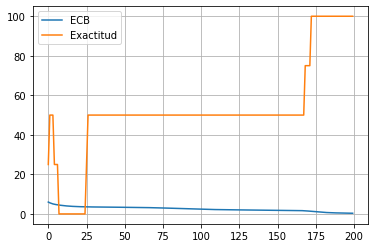

In [10]:
import matplotlib.pyplot as plt
plt.plot(np.arange(perdidas.size), perdidas, label='ECB')
plt.plot(np.arange(exactitudes.size), exactitudes, label='Exactitud')
plt.legend()
plt.grid(True)
plt.show()

## Actividad
Programar una red densa con tres entradas $x$ que aproxime los resultados esperados en $y$. Puede utilizar el ejemplo de Netflix previo, como se define en la siguiente tabla:<br>

| $x_1$ | $x_2$ | $x_2$ | $y$ | 
| ----- | :----:| :----:| :--:|
0       |  0    |     0 |        0
1       |  0    |     0 |        0
0       |  1    |     0 |        0
1       |  1    |     0 |        0
0       |  0    |     1 |        1
1       |  0    |     1 |        1
0       |  1    |     1 |        1
1       |  1    |     1 |        1

O bien definir un problema distinto.

In [11]:
X = np.array([
        [0, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [1, 1, 0],
        [0, 0, 1],
        [1, 0, 1],
        [0, 1, 1],
        [1, 1, 1],
])
y = np.array([0,0,0,0,1,1,1,1])

In [13]:
W1, W2, perdidas, exactitudes = retropropagacion(X, y, alpha = 1.0, n_epocas = 10, n_ocultas = 10)

Epoch 0: Pérdida = 4.263440648363303 Exactitud = 87.5
Epoch 1: Pérdida = 5.603194439589945 Exactitud = 75.0
Epoch 2: Pérdida = 4.615475804545073 Exactitud = 75.0
Epoch 3: Pérdida = 3.6053955823717696 Exactitud = 75.0
Epoch 4: Pérdida = 2.63627410530399 Exactitud = 75.0
Epoch 5: Pérdida = 1.818491617320427 Exactitud = 87.5
Epoch 6: Pérdida = 1.2280207104575163 Exactitud = 100.0
Epoch 7: Pérdida = 0.8508625376288019 Exactitud = 100.0
Epoch 8: Pérdida = 0.6190060516823055 Exactitud = 100.0
Epoch 9: Pérdida = 0.47313770676687383 Exactitud = 100.0


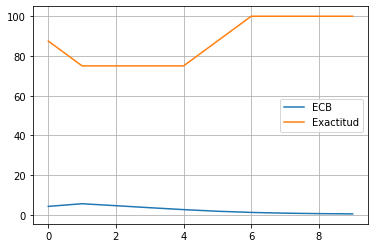

In [15]:
plt.plot(np.arange(perdidas.size), perdidas, label='ECB')
plt.plot(np.arange(exactitudes.size), exactitudes, label='Exactitud')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
sigmoide(W2)

array([[0.04757632],
       [0.67210822],
       [0.52858355],
       [0.07276733],
       [0.89338531],
       [0.11994347],
       [0.61993685],
       [0.55663406],
       [0.81924907],
       [0.826997  ]])